# Objective

We will investigate the data by focusing on PA and PS (Heures pleines)
-> Kmeans clustering on maxPA/MaxPM per month

# Import libraries, paths and tools

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import os
import random
pd.options.display.float_format = '{:.2f}'.format

In [2]:
#data repository
data_dir = Path(r'/Users/michaelargi/projects/perso/unsupervised/2024_04_05')
folder_path = data_dir

data_paths = {
    'pa':'Rlv_PA_PRM.csv',
    'pa_xlsx':'Rlv_PA_PRM.xlsx',
    'combined_data_month':'combined_data_month.csv',
    'anomalies':'EXPORT_ml_ANO_233.csv',
    'combined_data_Adjusted_Index_Change':'consolidated_with_Adjusted_Index_Change.csv',
    'data':'RLV_YY_2018_to_2024.xlsx',
    'train':'train.csv',
    'test':'test.csv',
    'validation':'validation.csv',
    'cleaned':'tmp/data_cleaned.csv',
    'ready':'tmp/data_ready.csv',
    'X_train':'tmp/train_features.csv',
    'y_train':'tmp/train_target.csv',
    'X_val':'tmp/val_features.csv',
    'y_val':'tmp/val_target.csv',
    'X_train_processed':'tmp/train_features_processed.csv',
    'X_val_processed':'tmp/val_features_processed.csv',
    'check':'tmp/check.csv',
    'dayoffs':'DAY_OFFS.csv'
}



In [3]:
class Environment:
    nb_clusters=10
    target_column_name = "Revised"
    should_rename_columns= False
    should_bin=False
    num_bins = 5
    nb_binning_limit = 20
    binned_suffix = "_BINNED"
    show_graphs = False
    should_normalize = False
    final_normalization= False
    def todict(self):
      return{
          "nb_clusters":self.nb_clusters,
          "target_column_name":self.target_column_name,
          "should_rename_columns":self.should_rename_columns,
          "should_bin":self.should_bin,
          "num_bins":self.num_bins,
          "nb_binning_limit": self.nb_binning_limit,
          "binned_suffix" :self.binned_suffix,
          "show_graphs" :self.show_graphs,
          "should_normalize" :self.should_normalize,
          "final_normalization": self.final_normalization
      }


ENV= Environment()


In [4]:
import csv,json
from datetime import datetime

def create_result_folder():
  prefix="results_"
  now = datetime.now()
  time_str = now.strftime("%Y%m%d_%H%M%S")
  folder_name = f"{prefix}{time_str}"
  folder_path = os.path.join(data_dir, folder_name)
  os.mkdir(folder_path)
  return folder_path

#folder_path=create_result_folder()

#save dict in file
def saveDictInFile(dict, file_name):
    print("saveDictInFile")
    os.makedirs(folder_path, exist_ok=True)
    csv_file_path = os.path.join(folder_path, file_name)
    with open(csv_file_path, "w", newline="") as fp:
      writer = csv.DictWriter(fp, fieldnames=dict.keys())
      writer.writeheader()
      writer.writerow(dict)

#save list in file
def write_list(a_list,file_name):
  csv_file_path = os.path.join(folder_path, file_name)
  df = pd.DataFrame(a_list)
  dataframe_to_csv(df,csv_file_path)

#Save dataframe to csv
def dataframe_to_csv(df,file_name):
  csv_file_path = os.path.join(folder_path, file_name)
  df.to_csv(csv_file_path, index=False)

def generate_name_based_on_time(prefix="Name_", suffix=""):
    now = datetime.now()
    time_str = now.strftime("%Y%m%d_%H%M%S")
    name = f"{prefix}{time_str}{suffix}"
    return name

saveDictInFile(ENV.todict(),"env.csv")

#result_file_name = "results.csv"

saveDictInFile


In [5]:
#utils
def encode_columns(data_frame, verbose=False):
  #Encoding
  label_encoder = LabelEncoder()
  for column in data_frame.columns:
      if column == ENV.target_column_name:
        data_frame[ENV.target_column_name] = data_frame[ENV.target_column_name].astype(int)
        if verbose:
          print("Don't encode target, we convert to int")
        continue
      if data_frame[column].dtype == 'object':  # Check if the column is of type 'object' (string)
          data_frame[column] = label_encoder.fit_transform(data_frame[column])
      elif data_frame[column].dtype == 'bool':
          data_frame[column].replace({True: 1, False: 0},inplace=True)
      else:
        if verbose:
          print("encode_columns error "+column+" ")
        #print(data_frame[column].dtype)


def drop_columns(data_frame,columns_to_drop, verbose=False):
  data_frame_copy = data_frame.copy()
  for column in columns_to_drop:
    if column in data_frame_copy.columns:
        if verbose:
            print("dropping column")
        data_frame_copy.drop(columns=column, inplace=True)
    else:
        if verbose:
            print(f"Column '{column}' does not exist in the DataFrame.")
  return data_frame_copy

In [6]:
def is_key_column(col):
  nb_unique_values = col.nunique()
  return nb_unique_values>100 and  nb_unique_values/col.count()>0.7

def is_binnable(col,nb_bins):
  nb_unique_values = col.nunique()
  return nb_unique_values>nb_bins and nb_unique_values> ENV.nb_binning_limit

def normalize(df:pd.DataFrame, col_name:str, factor):
  min = df[col_name].min()
  max = df[col_name].max()
  df[col_name]=(df[col_name]-min)/(max - min) * factor

#Clear folder's content, delete all file inside
def clear_folder(folder_path):
  files = os.listdir(folder_path)
  for file in files:
      file_path = os.path.join(folder_path, file)
      if os.path.isfile(file_path):
          os.remove(file_path)



In [7]:
#binning
from sklearn.tree import DecisionTreeRegressor

def create_bin_column(df:pd.DataFrame,column:str,num_bins:int, optional_bin_edges = None, verbose = False):
  if column == ENV.target_column_name:
    return

  if verbose:
    print("binning "+column)
  col = df[column]
  target_column_name= ENV.target_column_name
  target = df[target_column_name]
  if verbose:
    print("min",col.min())
    print("max",col.max())
  if col.nunique() <= num_bins:
    if verbose:
      print("too few for binning, returning")
    return
  if(optional_bin_edges):
    bin_edges = optional_bin_edges
  else:
    nb_leaves= num_bins
    tree = DecisionTreeRegressor(max_leaf_nodes=nb_leaves )
    tree.fit(df[[column]], target)

    # Use the decision tree to assign each data point to a bin
    bin_edges = tree.tree_.threshold[tree.tree_.feature != -2]

    # You might want to add the minimum and maximum edges
    bin_edges = np.concatenate(([col.min()], bin_edges, [col.max()]))
    if verbose:
      print(bin_edges)

    # Sort the array to ensure correct order of bin edges
    bin_edges.sort()

  # Print bin edges
  if verbose:
    print("Bin edges:", bin_edges)

  df[column + ENV.binned_suffix] = pd.cut(df[column], bins=bin_edges, include_lowest=True, labels=range(num_bins))

  return bin_edges


In [8]:
def transform_column_name(name):
    # Remove trailing spaces, replace special characters with underscores, and convert to capital letters
    return name.strip().replace(' ', '_').replace('@', '_').upper()

# Function to get pa data, from csv or xlsx

In [9]:
def get_pa_data(regenerate = False):
    print("get_pa_data")
    export_path = os.path.join(folder_path,data_paths['pa'])
    
    columns_to_drop=['']
    dtype_spec = {'PS': 'string','PA':'string','Nom_Cadran_PA':'string'}
    
    def replace_dots_and_commas(value):
        if ',' in value:
            return value.replace('.', '').replace(',', '.')
        else:
            return value
    
    def make_float(column):
        column = column.apply(replace_dots_and_commas)
        #column = column.str.split(',').str[0]  # This keeps '218.3' as is and changes '1.500,000' to '1.500'
        column = pd.to_numeric(column, errors='coerce') 
        return column
    
    def export_pa():
        print("export_pa")
        column_name_mapping = {
            'Date_relevé': 'Date_de_releve',
            'Numéro_relevé': 'Numero_releve',
            'Numéro_Cadran_PA':'Numero_Cadran_PA'
        }
        
        rl_folder_path = os.path.join(data_dir, 'ML_Export_rlv')
        data_frames = []
        for filename in os.listdir(rl_folder_path):
            if filename.endswith('.csv'):
                print("adding "+filename)
                file_path = os.path.join(rl_folder_path, filename)
                df = pd.read_csv(file_path,dtype=dtype_spec,encoding='utf-8',low_memory=False)
                print(df.columns)
                df.columns = df.columns.str.replace(' ', '', regex=False)
                df = drop_columns(df,columns_to_drop)
                if set(column_name_mapping.keys()).intersection(df.columns):
                    df.rename(columns=column_name_mapping, inplace=True)
                #na_counts_before = df['Puissance_souscrite'].isna().sum()
                df['PA']=make_float(df['PA'])
                df['PS']=make_float(df['PS'])
                
                data_frames.append(df)
        combined_df = pd.concat(data_frames, ignore_index=True)
        print("COMBINED")
        print(combined_df.columns)
        
        #only Heures pleines, keep only Nom_Cadran_PA with S_PA_HPH or S_PA_HPE
        combined_df = combined_df.loc[combined_df['Nom_Cadran_PA'].isin(['S_PA_HPH', 'S_PA_HPE'])]
        
        print("Generating new columns")
        combined_df['Cadran_key'] = combined_df['PRM'].astype(str) + "_" + combined_df['Numero_Cadran_PA'].astype(str)
        combined_df.sort_values(by=['Cadran_key', 'Date_de_releve'], inplace=True)
        #df.rename(columns=transform_column_name, inplace=True)
        dataframe_to_csv(combined_df, data_paths['pa'])
        return combined_df
        
    if os.path.isfile(export_path) and not regenerate:
        pa_df = pd.read_csv(export_path,dtype=dtype_spec,low_memory=False)
        pa_df = drop_columns(pa_df,columns_to_drop)
    else:
        pa_df = export_pa()
    
    print("reformating")
    pa_df['Date_de_releve']=pd.to_datetime(pa_df['Date_de_releve'], format='%Y%m%d')
    pa_df['month'] = pa_df['Date_de_releve'].dt.strftime('%Y-%m')
    pa_df['month']= pa_df['month'].astype('string')
    pa_df['Cadran_key']= pa_df['Cadran_key'].astype('string')
    pa_df['PA'] = pa_df['PA'].astype(float)
    pa_df['PS'] = pa_df['PS'].astype(float)

    return pa_df

pa_df = get_pa_data()


unique_months = pa_df['month'].unique()
unique_months_list = unique_months.tolist()
print(unique_months_list)

print(pa_df.columns)
print(pa_df.dtypes)


get_pa_data
reformating
['2022-11', '2022-12', '2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02']
Index(['Date_de_releve', 'PRM', 'Numero_releve', 'Nom_Cadran_PA',
       'Numero_Cadran_PA', 'PA', 'PS', 'Cadran_key', 'month'],
      dtype='object')
Date_de_releve      datetime64[ns]
PRM                          int64
Numero_releve                int64
Nom_Cadran_PA               string
Numero_Cadran_PA             int64
PA                         float64
PS                         float64
Cadran_key                  string
month                       string
dtype: object


# First view of data



In [10]:
show_describe= True
 
if ENV.should_rename_columns:
  pa_df.rename(columns=transform_column_name, inplace=True)
  ENV.target_column_name = ENV.target_column_name.upper()

if show_describe:
    print("\nhead")
    print("=" * 40)
    print(pa_df.head(5))
    
    print("\tail")
    print("=" * 40)
    print(pa_df.tail(5))
    
    print('This is the Shape of the data')
    print('='*49)
    print("The total number of columns: ", pa_df.shape[1])
    print("The total number of rows: ", pa_df.shape[0])
    print('='*49)

    print('\nTypes of the Dataset:')
    print("=" * 40)
    print(pa_df.dtypes)

    print('\nDescription of the numerical Dataset:')
    print("=" * 40)
    numerical_description = pa_df.describe(include=['int', 'float']).T
    print(numerical_description)
    
    if any(pa_df.dtypes == 'object') or any(pa_df.dtypes == 'bool'):
        print('\nDescription of the Categorical Dataset:')
        print("=" * 40)
        categorical_description = pa_df.describe(include=['object', 'bool']).T
        print(categorical_description)

    print('\nDescription of the nb values:')
    print("=" * 40)
    value_counts_per_column = pa_df.nunique()

    # Convert the Series to a DataFrame for better table display
    value_counts_df = value_counts_per_column.reset_index()
    print(value_counts_df)

    # Define a styling function
    def style_description(s):
        return f'background-color: lightblue; font-weight: bold;'

    # Apply the styling to the DataFrame
    #styled_description = categorical_description.style.applymap(style_description)
    #styled_description
    #print(styled_description)

    print("\nis null")
    print("=" * 40)
    print(pa_df.isnull().sum())
    
    print("\nis nan")
    print("=" * 40)
    print(pa_df.isna().sum())


    print("done")





head
  Date_de_releve     PRM  Numero_releve Nom_Cadran_PA  Numero_Cadran_PA    PA  \
0     2022-11-11  292561     3714275164      S_PA_HPH                47 91.00   
1     2022-12-11  292561     3755982832      S_PA_HPH                47 89.00   
2     2023-01-11  292561     3800430465      S_PA_HPH                47 88.00   
3     2023-02-11  292561     3844798948      S_PA_HPH                47 64.00   
4     2023-03-11  292561     3886167070      S_PA_HPH                47  2.00   

     PS Cadran_key    month  
0 95.00  292561_47  2022-11  
1 95.00  292561_47  2022-12  
2 95.00  292561_47  2023-01  
3 95.00  292561_47  2023-02  
4 95.00  292561_47  2023-03  
	ail
        Date_de_releve     PRM  Numero_releve Nom_Cadran_PA  Numero_Cadran_PA  \
3822335     2023-10-06  524304     4182470966      S_PA_HPH                52   
3822336     2023-11-06  524304     4226932925      S_PA_HPH                52   
3822337     2023-12-06  524304     4269901458      S_PA_HPH                52  

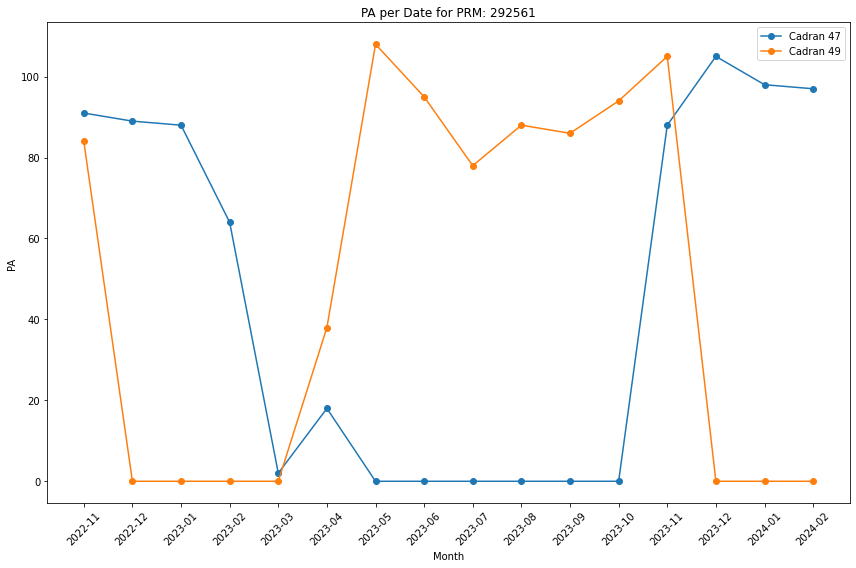

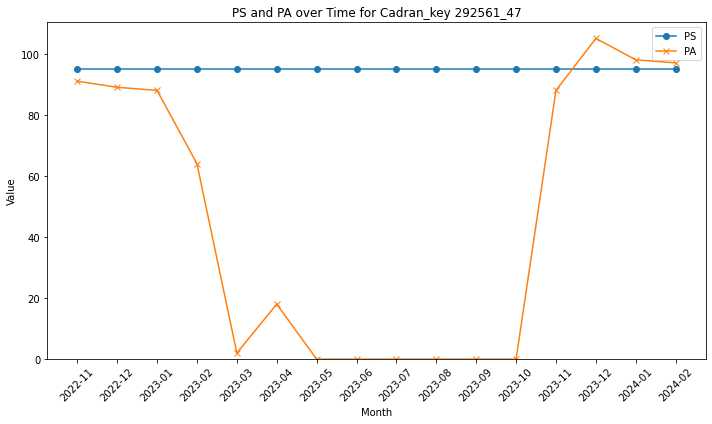

In [11]:
def plot_PA_per_date_for_prm(df, prm,saveName=""):
    filtered_df = df[df['PRM'] == prm]
    # Get unique 'Cadran' values
    cadran_values = filtered_df['Numero_Cadran_PA'].unique()
    plt.figure(figsize=(12, 8))  # Adjust figure size as needed
    # Loop through each 'Cadran' value and plot
    for cadran in cadran_values:
        subset_df = filtered_df[filtered_df['Numero_Cadran_PA'] == cadran]
        plt.plot(subset_df['month'], subset_df['PA'], marker='o', label=f'Cadran {cadran}')
    
    plt.title(f'PA per Date for PRM: {prm}')
    plt.xlabel('Month')
    plt.ylabel('PA')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    if saveName:
        plt.savefig(saveName)
        plt.close()
    else:
        plt.show()


plot_PA_per_date_for_prm(pa_df,292561)

def plot_PA_AND_PS_per_date_for_Cadran(df, cadran_key):
    cadran_key = str(cadran_key)
    specific_cadran_df = df[df['Cadran_key'] == cadran_key]
    plt.figure(figsize=(10, 6))
    plt.plot(specific_cadran_df['month'], specific_cadran_df['PS'], label='PS', marker='o')  # PS line
    plt.plot(specific_cadran_df['month'], specific_cadran_df['PA'], label='PA', marker='x')  # PA line
    plt.ylim(bottom=0) 
    # Formatting the plot
    plt.title(f'PS and PA over Time for Cadran_key {cadran_key}')
    plt.xlabel('Month')
    plt.ylabel('Value')
    plt.xticks(rotation=45)  # Rotate dates for better readability
    plt.legend() 
    plt.tight_layout()
    plt.show()

pa_df['PA'] = pa_df['PA'].astype(float)
pa_df['PS'] = pa_df['PS'].astype(float)

plot_PA_AND_PS_per_date_for_Cadran(pa_df,'292561_47')
    


def print_Date_de_Releve_for_Cadran_key(df, specific_cadran_key):
    filtered_df = df[df['Cadran_key'] == specific_cadran_key]
    print(filtered_df['Date_de_releve'])
    
#print_Date_de_Releve_for_Cadran_key(consolidated_df,'41036856101_1')


    


# Clustering

## Agregation per PRM/Month and instertion maxPA/MaxPM

In [12]:
def get_aggregated_data_per_month(regenerate = False):
    export_path = os.path.join(folder_path,data_paths['combined_data_month'])
    print("get_aggregated_data_per_month from "+export_path)
    columns_to_drop=['']
    #dtype_spec = {'PS': 'string','PA':'string','Nom_Cadran_PA':'string'}

    
    def export():
        df = get_pa_data()
        print("export")
        column_name_mapping = {
        }
        
        aggregated = df.groupby(['PRM', 'month']).agg(
            maxPA=('PA', 'max'),
            maxPS=('PS', 'max')
        ).reset_index()
        print(aggregated.head())
        print(aggregated.dtypes)
        aggregated['maxPA']=aggregated['maxPA'].astype('float')
        aggregated['maxPS']=aggregated['maxPS'].astype('float')
        print(aggregated.dtypes)
        aggregated['maxPA/maxPS']=aggregated['maxPA']/aggregated['maxPS']
        dataframe_to_csv(aggregated, data_paths['combined_data_month'])
        return aggregated
        
    if os.path.isfile(export_path) and not regenerate:
        aggregated = pd.read_csv(export_path,low_memory=False)
        aggregated = drop_columns(aggregated,columns_to_drop)
    else:
        aggregated = export()
    
    
    return aggregated

aggregated_df_per_month = get_aggregated_data_per_month()
print(f'nb PRMs x months is {len(aggregated_df_per_month)}')


get_aggregated_data_per_month from /Users/michaelargi/projects/perso/unsupervised/2024_04_05/combined_data_month.csv
nb PRMs x months is 1908076


## Creating a pivot table with PRM as index and months as columns

In [13]:
# like a pivot table in XL=> month in columns 
pivot_df = aggregated_df_per_month.pivot(index='PRM', columns='month', values='maxPA/maxPS')
print(pivot_df.columns)

Index(['2022-11', '2022-12', '2023-01', '2023-02', '2023-03', '2023-04',
       '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10',
       '2023-11', '2023-12', '2024-01', '2024-02'],
      dtype='object', name='month')


## Filtering PRM with data for all months

In [14]:
pivot_df_with_all_months = pivot_df.dropna().copy()

#print(pivot_df_with_all_months)
print(len(pivot_df_with_all_months))

83537


## Let's clusterize these PRMs with data for all months 

standardizing
Clustering
month   2022-11  2022-12  2023-01  2023-02  2023-03  2023-04  2023-05  \
PRM                                                                     
292561     0.96     0.94     0.93     0.67     0.02     0.40     1.14   
292562     0.77     0.73     0.85     0.92     0.60     0.69     0.73   
292563     0.75     0.68     0.68     0.00     0.62     0.50     0.53   
292564     0.22     0.46     0.88     0.83     0.88     0.78     0.70   
292567     0.25     0.53     0.31     0.12     0.52     0.27     0.12   

month   2023-06  2023-07  2023-08  2023-09  2023-10  2023-11  2023-12  \
PRM                                                                     
292561     1.00     0.82     0.93     0.91     0.99     0.93     1.11   
292562     0.52     0.65     0.56     0.60     0.75     0.88     0.92   
292563     0.59     0.56     0.59     0.59     0.56     0.50     0.53   
292564     0.17     0.66     0.79     0.79     0.18     0.24     0.92   
292567     0.50     0.30 

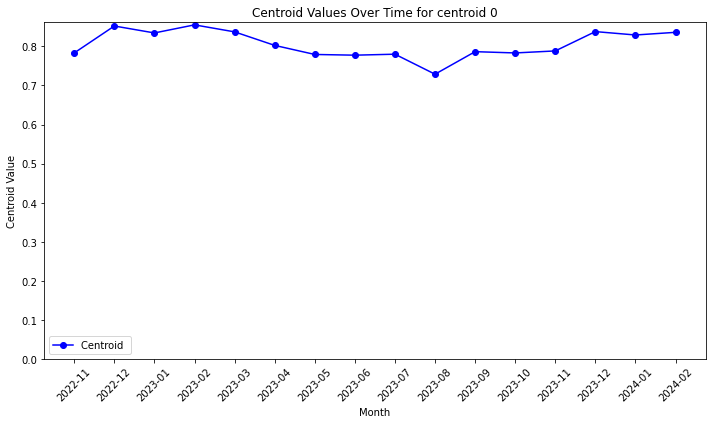

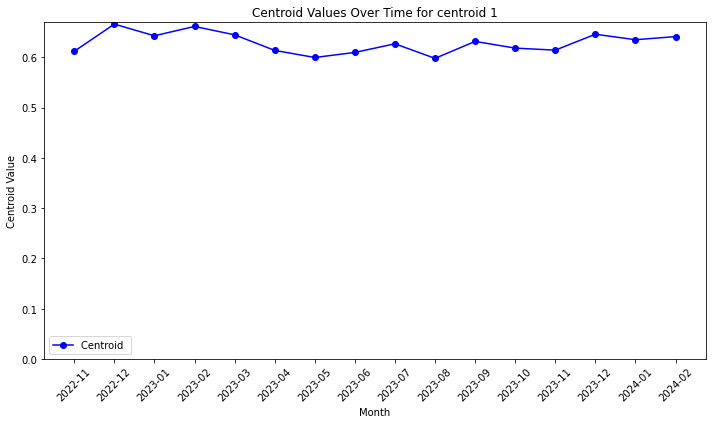

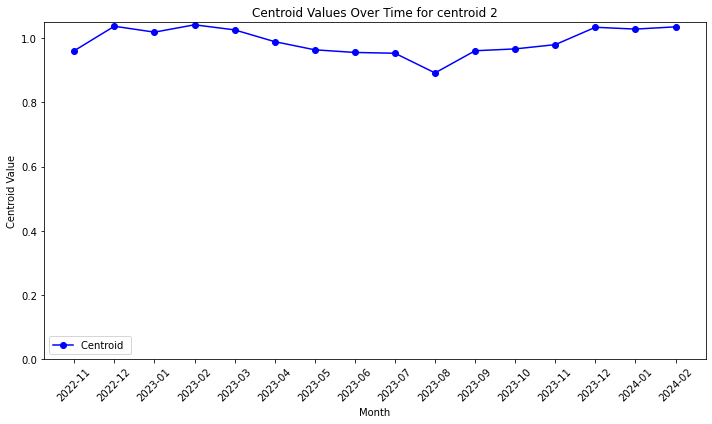

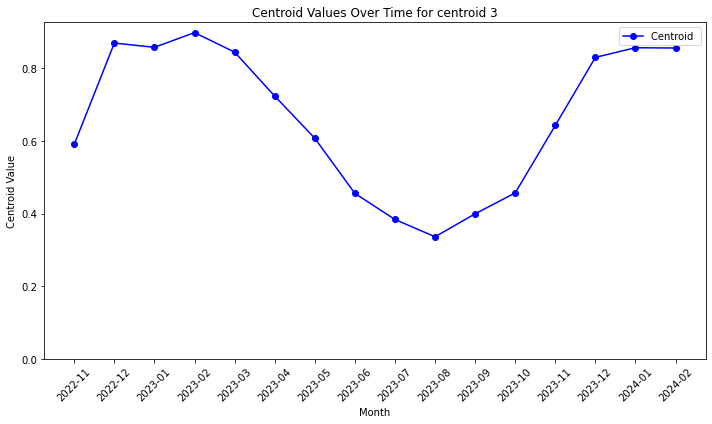

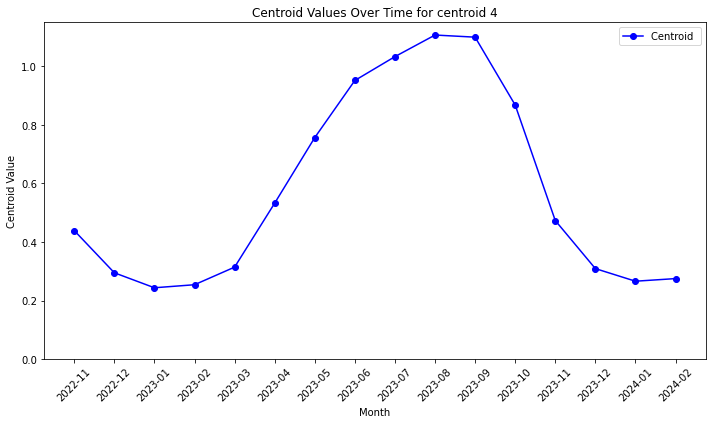

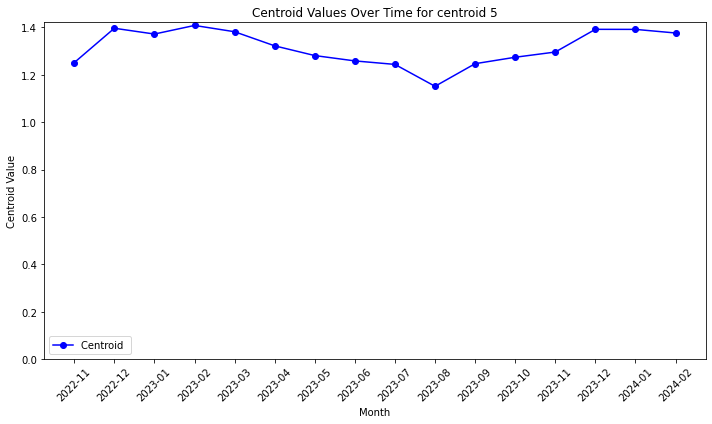

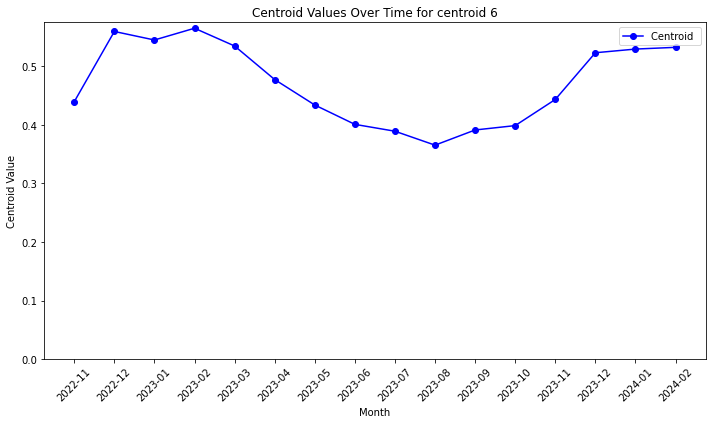

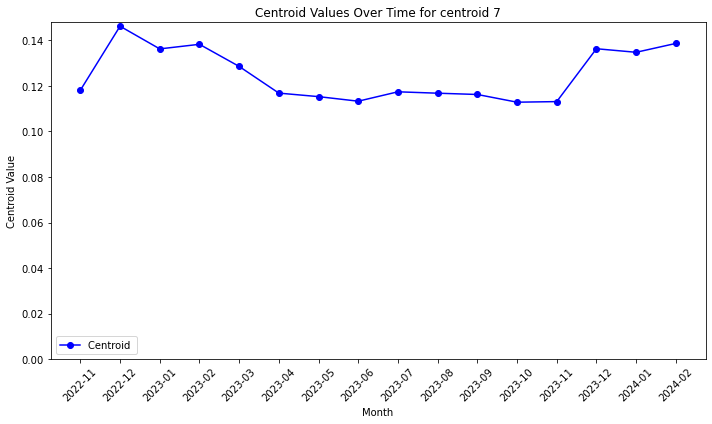

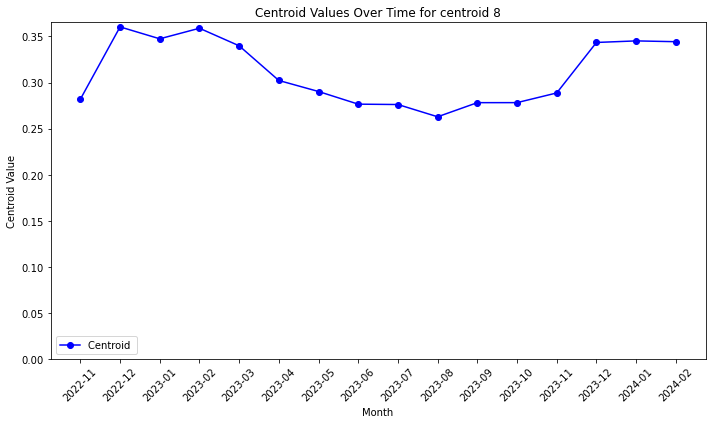

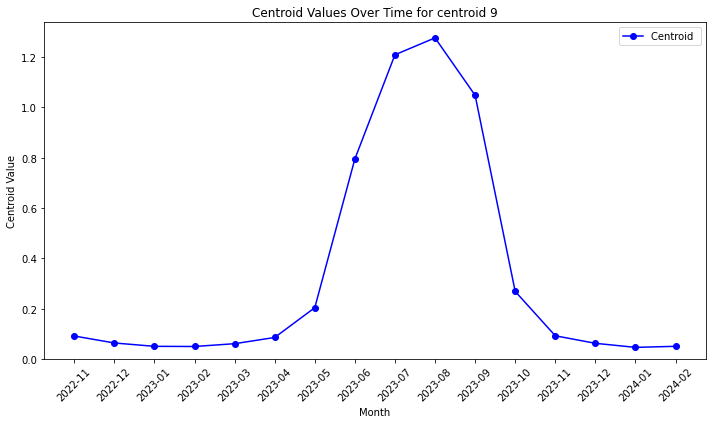

In [15]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import Counter

nb_clusters = ENV.nb_clusters

# Fit and transform the data with StandardScaler
print("standardizing")
scaler = StandardScaler()
scaled_features = scaler.fit_transform(pivot_df_with_all_months)

# Apply KMeans Clustering
print("Clustering")
kmeans = KMeans(n_clusters=nb_clusters)
kmeans.fit(scaled_features)  # Ensure you fit the scaled features

# Correctly assign cluster labels to the original DataFrame
#pivot_df_with_all_months['cluster'] = kmeans.labels_
#pivot_df_with_all_months = drop_columns(pivot_df_with_all_months,['cluster'])

print(pivot_df_with_all_months.head())

# If you need to work with the centroids in their original scale
centroids_original_scale = scaler.inverse_transform(kmeans.cluster_centers_)


# Print the centroids in their original scale
#print(centroids_original_scale)
def plot_centroid(id,months,centroids_original_scale):
    values = centroids_original_scale[id]
    plt.figure(figsize=(10, 6))
    plt.plot(months, values, label='Centroid ', marker='o', linestyle='-', color='blue')
    
    # Formatting the plot
    plt.title(f'Centroid Values Over Time for centroid {id}')
    plt.ylim(bottom=0) 
    plt.xlabel('Month')
    plt.ylabel('Centroid Value')
    plt.xticks(months, labels=months, rotation=45)  # Set x-ticks labels explicitly if needed
    plt.legend()

    plt.tight_layout()  # Adjust layout to make room for the rotated x-tick labels
    plt.show()


    
exclude_columns = ['cluster', 'MaxDistColumn', 'SignedMaxDistance', 'MaxDistance']
filtered_columns = [col for col in pivot_df_with_all_months.columns if col not in exclude_columns]


cluster_counts = Counter(kmeans.labels_)
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} PRMs")
    
for i in range(0,len(centroids_original_scale)):
    plot_centroid(i,filtered_columns,centroids_original_scale)



## Then assign all PRMs to clusters

In [16]:
import numpy as np

pivot_df = drop_columns(pivot_df,['cluster'])
# Assuming centroids_original_scale contains the centroids in their original scale

def distance_to_centroid(row, centroid):
    # Calculate the sum of absolute differences, ignoring NaN values
    valid_indices = ~np.isnan(row)
    return np.sum(np.abs(row[valid_indices] - centroid[valid_indices]))

# Initialize a list to hold the cluster assignments
cluster_assignments = []

# Iterate over each row in pivot_df
for index, row in pivot_df.iterrows():
    row_values = row.values  # Convert the row to a NumPy array for easier element-wise operations
    min_distance = -1
    cluster = -1
    cluster_index = 0
    
    # Iterate over each centroid to find the closest one
    for centroid in centroids_original_scale:
        distance = distance_to_centroid(row_values, centroid)
        if min_distance == -1 or distance < min_distance:
            min_distance = distance
            cluster = cluster_index
        cluster_index += 1
    
    # Assign the closest cluster to the row
    cluster_assignments.append(cluster)

# Assign the cluster assignments back to the DataFrame
pivot_df['cluster'] = cluster_assignments
#print(pivot_df.head())


# Find outliers

In [17]:
pivot_df['cluster'] = pivot_df['cluster'].astype(int)
#print(pivot_df.dtypes)
#print(centroids_original_scale)

def calculate_distances(row):
    cluster = int(row['cluster'])
    
    # Retrieve the centroid for the assigned cluster
    centroid = centroids_original_scale[cluster]
    # Calculate the differences for all columns (ignoring NaN in original data)
    distances = row.values[:-1] - centroid  # Exclude the cluster label from row values
    
    # Find the index of the maximum absolute distance
    max_abs_distance_index = np.argmax(np.abs(distances))
    # Use this index to find the signed maximum distance
    signed_max_distance = distances[max_abs_distance_index]
    
    # Get the column name corresponding to the maximum (absolute) distance
    max_distance_column = pivot_df.columns[max_abs_distance_index]
    
    return pd.Series([max_distance_column, signed_max_distance], index=['MaxDistColumn', 'SignedMaxDistance'])

# Apply the modified function to each row and assign the results to new columns
pivot_df[['MaxDistColumn', 'SignedMaxDistance']] = pivot_df.apply(calculate_distances, axis=1)
pivot_df['MaxDistance'] = pivot_df['SignedMaxDistance'].abs()

# Now, sort pivot_df by 'MaxDistance' in descending order to see the most anomalous entries first
pivot_df_sorted = pivot_df.sort_values(by='MaxDistance', ascending=False)

pivot_df_sorted_and_filtered = pivot_df_sorted[pivot_df_sorted['SignedMaxDistance']<0]

print(pivot_df_sorted_and_filtered.head())


month   2022-11  2022-12  2023-01  2023-02  2023-03  2023-04  2023-05  \
PRM                                                                     
312378     1.83     0.00     0.00     0.00     2.07     1.76     1.81   
321552     0.00     0.00     0.00     0.00     1.95     1.64     1.29   
482692     1.41     1.67     1.33     0.01     1.26     0.01     0.01   
301381     1.24     0.00     1.29     1.31     1.21     1.21     1.24   
316045     0.00     0.00     0.00     1.57     1.38     1.31     1.19   

month   2023-06  2023-07  2023-08  2023-09  2023-10  2023-11  2023-12  \
PRM                                                                     
312378     1.14     1.17     1.19     1.17     1.29     1.57     1.69   
321552     1.41     1.64     1.27     1.39     1.15     1.11     1.79   
482692     1.41     1.16     1.13     1.12     1.01     1.56     1.65   
301381     1.24     1.02     0.71     1.12     1.31     1.29     1.31   
316045     1.29     1.24     0.26     1.17     1.3

Displaying PRM 312378 for month 2023-02 in cluster 5


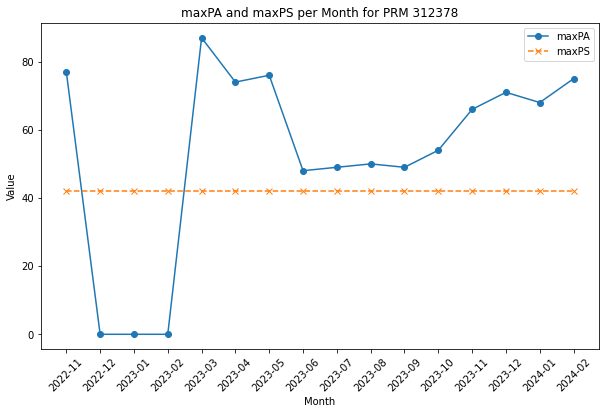

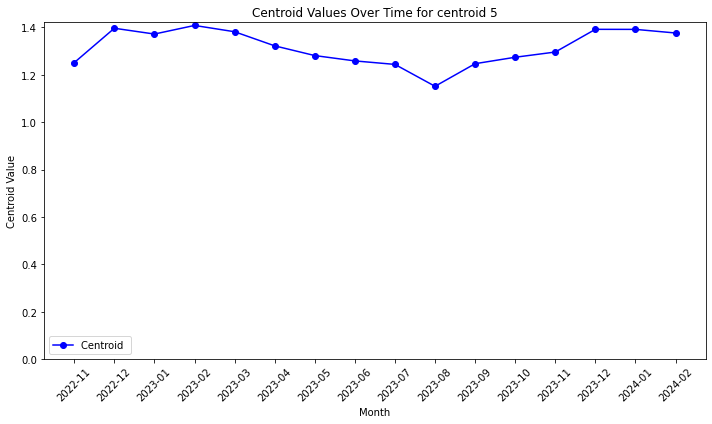

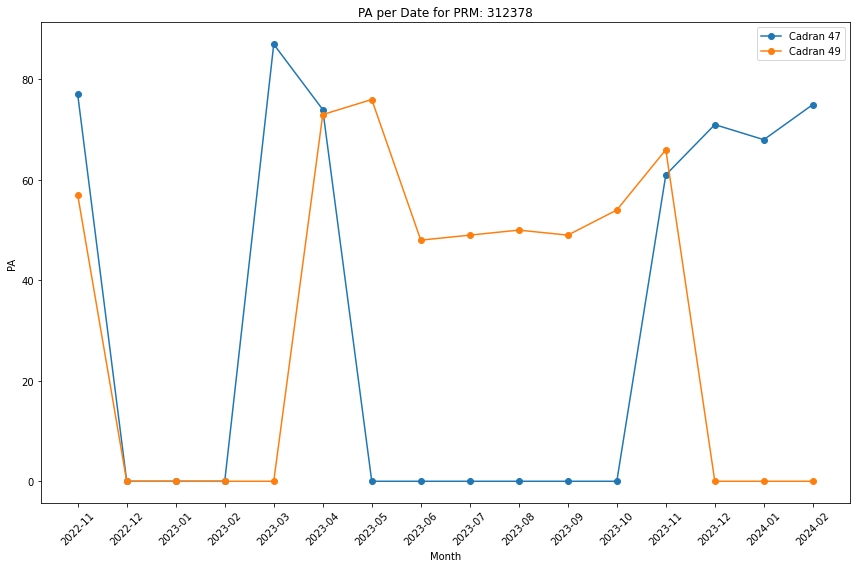

Displaying PRM 321552 for month 2023-02 in cluster 5


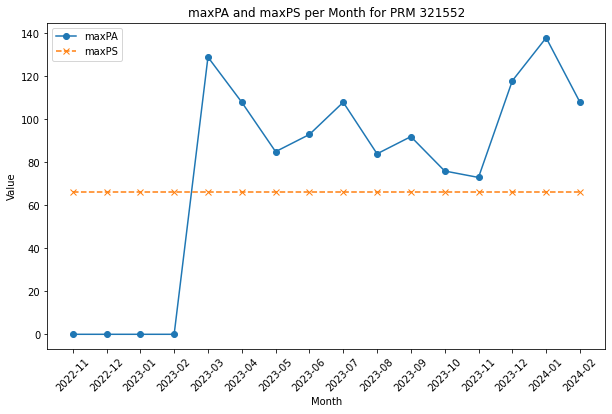

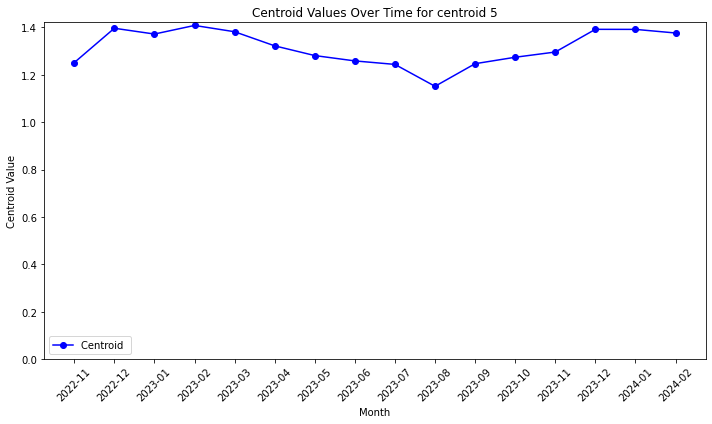

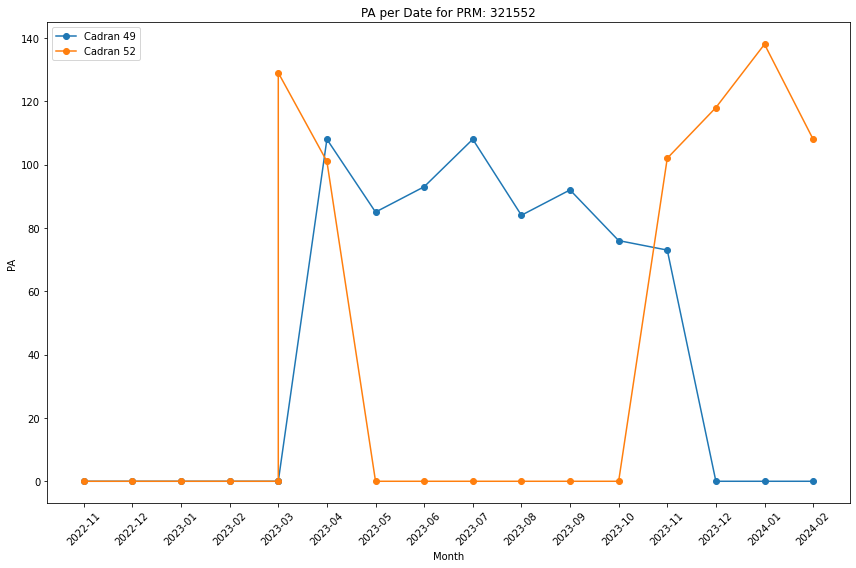

Displaying PRM 482692 for month 2023-02 in cluster 5


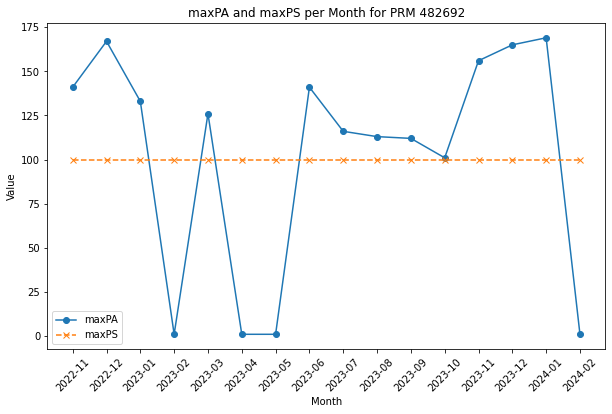

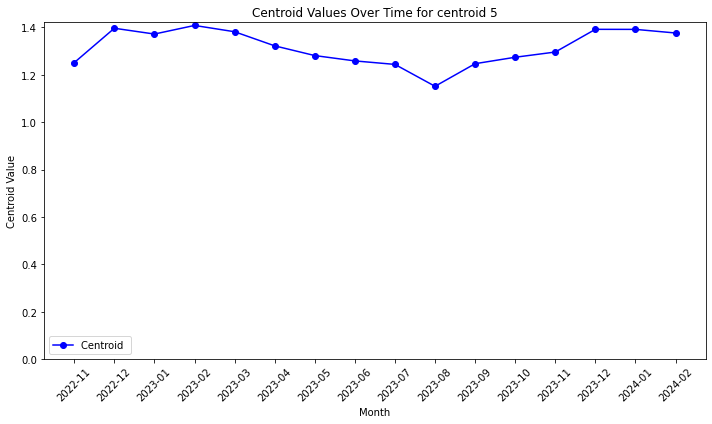

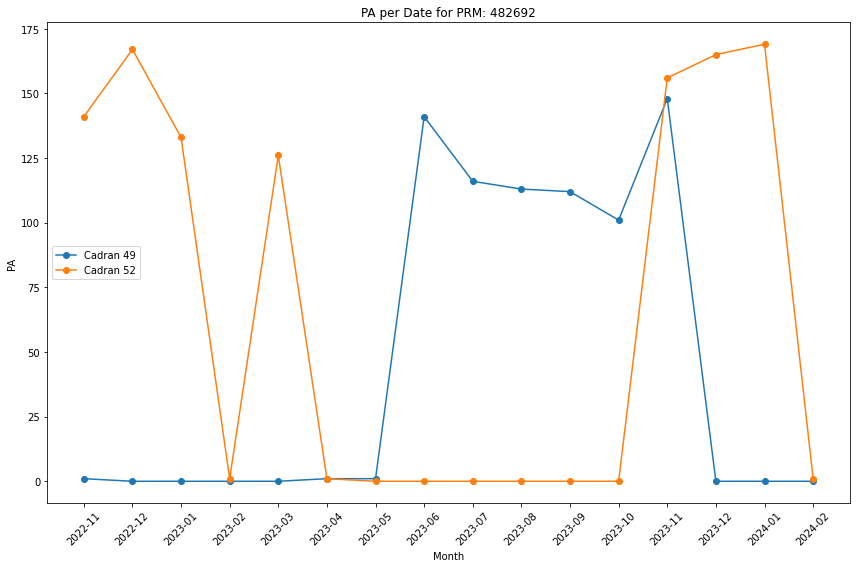

Displaying PRM 301381 for month 2022-12 in cluster 5


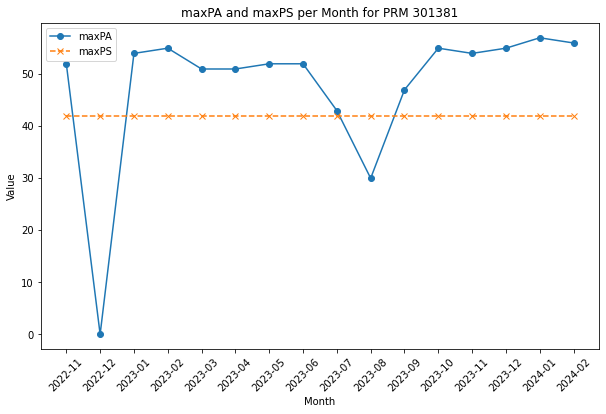

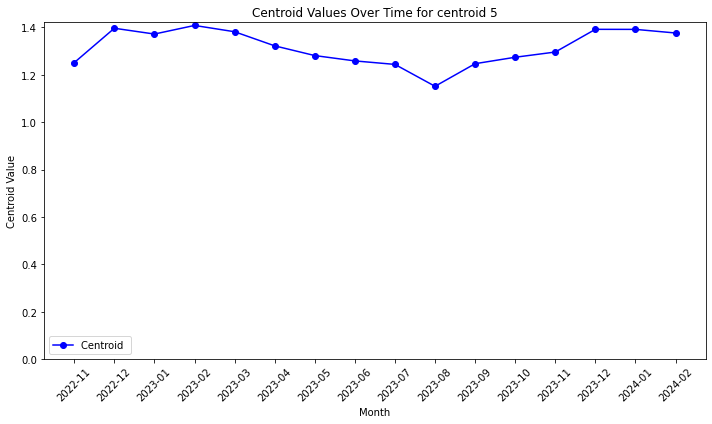

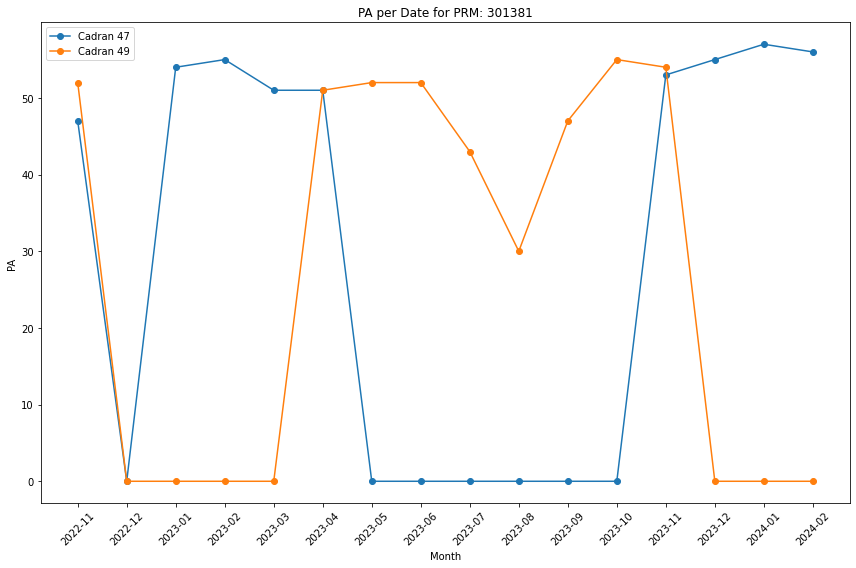

Displaying PRM 316045 for month 2022-12 in cluster 5


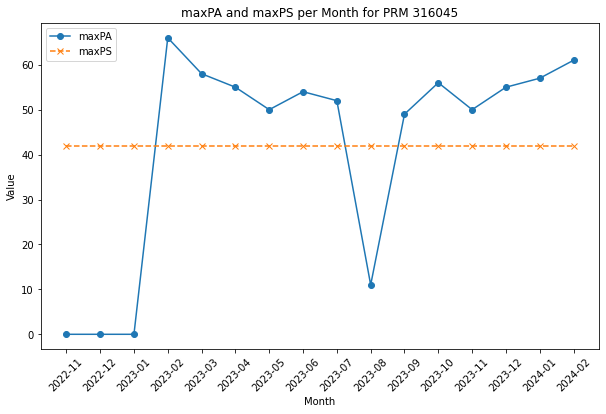

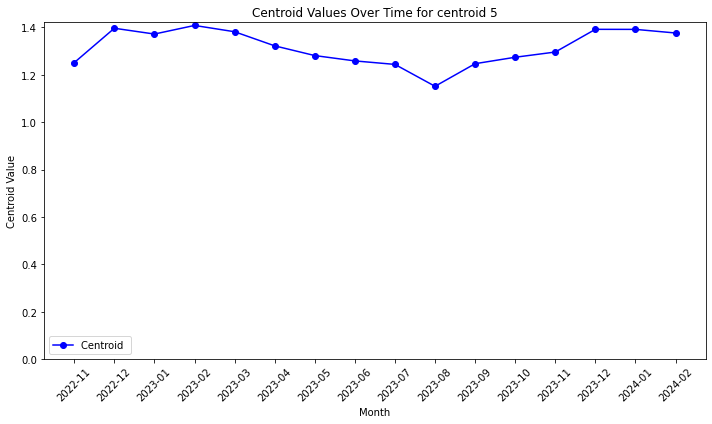

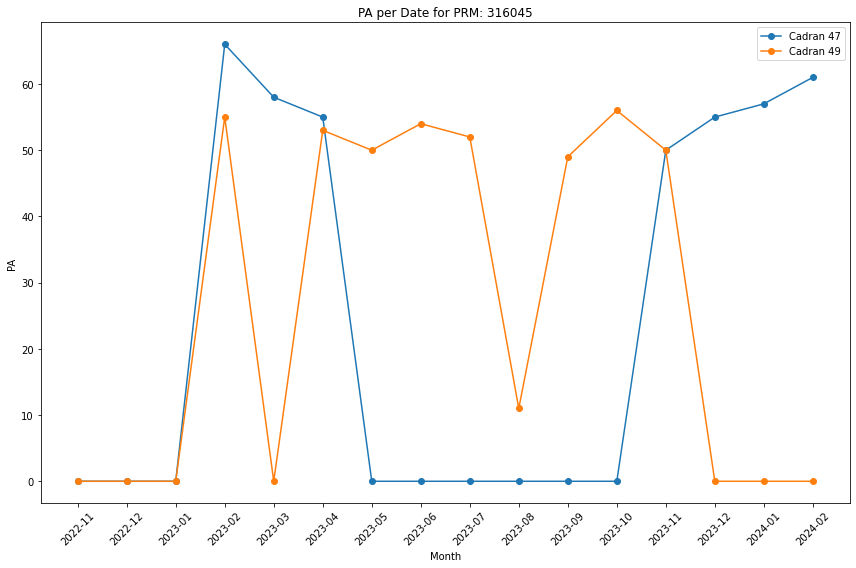

In [25]:
def plot_maxPA_maxPM_per_date_for_prm(df, prm,saveName=""):
    df_filtered = df[df['PRM'] == prm]
    plt.figure(figsize=(10, 6))
    plt.plot(df_filtered['month'], df_filtered['maxPA'], marker='o', linestyle='-', label='maxPA')
    plt.plot(df_filtered['month'], df_filtered['maxPS'], marker='x', linestyle='--', label='maxPS')

    # Formatting the plot
    plt.title(f'maxPA and maxPS per Month for PRM {prm}')
    plt.xlabel('Month')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.legend()
    if saveName:
        plt.savefig(saveName)
        plt.close()
    else:
        plt.show()
        

#print(pivot_df_sorted_and_filtered.head())

#print(centroids_original_scale)

exclude_columns = ['cluster', 'MaxDistColumn', 'SignedMaxDistance', 'MaxDistance']
filtered_columns = [col for col in pivot_df.columns if col not in exclude_columns]

first_five_prms = pivot_df_sorted_and_filtered.index[:5]

for prm in first_five_prms:
    prm_cluster = pivot_df_sorted_and_filtered.loc[prm, 'cluster']
    prm_month = pivot_df_sorted_and_filtered.loc[prm, 'MaxDistColumn']
    print(f'Displaying PRM {prm} for month {prm_month} in cluster {prm_cluster}')

    plot_maxPA_maxPM_per_date_for_prm(aggregated_df_per_month,prm)
    plot_centroid(prm_cluster,filtered_columns,centroids_original_scale)
    plot_PA_per_date_for_prm(pa_df,prm)


In [27]:

filtered_data = pa_df[(pa_df['PRM'] == 312378) & (pa_df['month'] == "2023-03")]

print(filtered_data)

       Date_de_releve     PRM  Numero_releve Nom_Cadran_PA  Numero_Cadran_PA  \
525852     2023-03-15  312378     3890651768      S_PA_HPH                47   
525868     2023-03-15  312378     3890651770      S_PA_HPE                49   

          PA    PS Cadran_key    month  
525852 87.00 42.00  312378_47  2023-03  
525868  0.00 42.00  312378_49  2023-03  
